# Investigate FSS-B behavior since 2014 at pitch < 135 deg

This notebook investigates the trending of pitch and roll errors in the Fine Sun Sensor (FSS) B-side.
In contrast to the [FSS daily check page](https://cxc.cfa.harvard.edu/mta/ASPECT/fss_check3/), this
focuses on roll/pitch errors when the spacecraft pitch angle is below 135 deg with indicated 
sun presence.

### Summary

The pitch (beta) channel of FSS-B has remained stable and accurate since 2014, but 
recently in 2023 isolated pitch errors of to 0.5 deg have been seen.

Errors outside of the nominal FSS accuracy started appearing in the roll (alpha) channel
starting around 2017. These errors started at tail sun near the 135 limit of this
analysis.

Since about 2021 the envelope of substantial roll errors (over 1 deg of error) has been
expanding to lower pitch and showing a wider distribution.

In 2022-2023 FSS roll errors of over 1.5 deg have been observed at large off-nominal
roll and pitch angles below 127 deg. Here the planning limit for roll is 18.5 deg.

*Prior to returning to operations with the FSS-B enabled, we should consider reducing
the planning limit.*

### References

- [A_FSSCALC.tlm (raw counts to pitch/roll angle on OBC)](https://occweb.cfa.harvard.edu/twiki/pub/Aspect/StarWorkingGroupMeeting2020x01x15/A_FSSCALC.tlm)
- [FSS-B alignment investigation and calibration following 2015 safe mode](https://github.com/sot/safemode_2015264)
- [Chandra 2015 FSS-B Alignment and Field of View Calibration](https://occweb.cfa.harvard.edu/twiki/pub/SC_Subsystems/PCADSensors/Results_of_2015_FSS-B_Align__FOV_Calib.pdf)
- [PR-391 patch FSS to ACA align and FSS alpha/beta cross coupling](https://occweb.cfa.harvard.edu/occweb/FOT/engineering/flight_software/PATCHES/PR-391_Recalibrate_FSS-B/PR391_Recalibrate_FSS-B_11042016B.pdf)


In [1]:
import cheta.fetch_eng as fetch
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import ska_numpy
from astropy.table import Table, vstack
from Chandra.Time import DateTime
from cxotime import CxoTime
from kadi import events
from ska_matplotlib import plot_cxctime, set_min_axis_range
from bad_times import bad_times

matplotlib.style.use('bmh')
# %run check_fss

### FSS counts to angle calibration on OBC

This uses the on-board formula `angle = arctan(c0 + c1 * counts) + c2)`.

The ground TDB calibration is a 9th-order polynomial that approximates this. For
all this analysis we use the OBC angle since that is what matters for S/C operations.

In [2]:
FSS_OBC_CAL = {
    "a": {
        "alpha": [-1.190313, 0.00007261314, -0.00001571],
        "beta": [-1.190563, 0.00007264188, -0.00005934],
    },
    "b": {
        "alpha": [-1.190163, 0.00007266802, 0.0001902],
        "beta": [-1.19044, 0.00007265815, -0.0001902],
    },
}

### Align FSS to ACA (Chandra body) frame

In [3]:
# FSS-A from OFLS characteristics
ODB_FSS_MISALIGN = np.zeros([4, 4], dtype=np.float64)
ODB_FSS_MISALIGN[1, 1] = 9.999990450374580e-01
ODB_FSS_MISALIGN[2, 1] = -5.327615067743422e-07
ODB_FSS_MISALIGN[3, 1] = 1.381999959551952e-03
ODB_FSS_MISALIGN[1, 2] = 0.0
ODB_FSS_MISALIGN[2, 2] = 9.999999256947376e-01
ODB_FSS_MISALIGN[3, 2] = 3.855003493343671e-04
ODB_FSS_MISALIGN[1, 3] = -1.382000062241829e-03
ODB_FSS_MISALIGN[2, 3] = -3.854999811959735e-04
ODB_FSS_MISALIGN[3, 3] = 9.999989707322665e-01

# FSS-B reference PR-391 from W.S. Davis analysis which determined an alignment
# matrix which minimizes FSS pitch and roll errors.
FSS_TO_ACA = {
    "a": ODB_FSS_MISALIGN[1:, 1:],
    "b": [
        [0.99999147, -0.00348329, -0.00221858],
        [0.00347606, 0.99998865, -0.00325693],
        [0.00222990, 0.00324919, 0.99999224],
    ],
}

### TDB polynominal calibration coefficients

These are reversed for use in `np.polyval` and they get used to convert from
FSS angle in the CXC archive to raw counts.

In [4]:
ALPHA_ANG_PC = [-50.01873285, 0.001739300837, 4.202023792e-08, 9.617900394e-12, -1.570367949e-15,
                1.756637723e-19, -1.118788495e-23, 3.775679639e-28, -6.421573874e-33,
                4.369576818e-38][::-1]
BETA_ANG_PC = [-50.16789839, 0.001739575081, 4.202728171e-08, 9.631457701e-12, -1.573063077e-15,
               1.760037996e-19, -1.121133178e-23, 3.784196473e-28, -6.437103687e-33,
               4.380850442e-38][::-1]

In [5]:
# Generate a curve corresponding to the ground (TDB) calibration which
# gets numerically inverted to compute on-board counts from ground angle.
COUNTS = np.arange(40000)
ALPHA_ANG = np.polyval(ALPHA_ANG_PC, COUNTS)
BETA_ANG = np.polyval(BETA_ANG_PC, COUNTS)

In [6]:
# Variation of what will be in ska_helpers.utils

def cache_file(fn):
    """Cache the np.ndarray result of a function to a file.

    The cache file is in a local directory called "cache" and is named with the
    function name combined with the arguments and keyword arguments.

    The cache file is a pickle file with the function results.

    Parameters
    ----------
    fn : function

    Returns
    -------
    wrapped : function
    """
    import os
    from pathlib import Path

    def wrapped(*args, **kwargs):
        # define a wrapper that will finally call "fn" with all arguments
        # if cache exists -> load it and return its content
        if args:
            args_str = "_" + "_".join([str(arg) for arg in args])
        else:
            args_str = ""
        if kwargs:
            kwargs_str = "_" + "_".join(
                [f"{key}_{value}" for key, value in kwargs.items()]
            )
        else:
            kwargs_str = ""
        cachedir = Path("cache")
        cachedir.mkdir(exist_ok=True)
        cachefile = cachedir / f"{fn.__name__}{args_str}{kwargs_str}.npz"

        if os.path.exists(cachefile):
            with np.load(cachefile) as fh:
                res = fh["arr_0"]
        else:
            # execute the function with all arguments passed
            res = fn(*args, **kwargs)
            # write to cache file
            np.savez_compressed(cachefile, res)

        return res

    return wrapped

In [7]:
def fss_angle_ground_to_obc(angle, channel, fss='b'):
    """
    Convert ``angle`` from ground telemetry (AOALPANG or AOBETANG) to output ``angle``
    (degrees) in the OBC for the given ``channel`` ('alpha' or 'beta') and ``fss``
    ('a' or 'b').

    Parameters
    ----------
    angle : float, ndarray
        TDB (ground) calibration angle in degrees
    channel : {'alpha', 'beta'}
        FSS channel
    fss : {'a', 'b'}   
        FSS identifier

    Returns
    -------
    angle : float, ndarray
        OBC angle in degrees
    """
    y = ALPHA_ANG if channel == 'alpha' else BETA_ANG
    f_counts = ska_numpy.interpolate(COUNTS, y, angle)
    counts = ska_numpy.interpolate(COUNTS, y, angle, method='nearest')
    if np.any(np.abs(f_counts - counts) > 0.01):
        raise ValueError('Bad calibration inversion')

    c0, c1, c2 = FSS_OBC_CAL[fss][channel]
    angle = np.degrees(np.arctan(c0 + c1 * counts) + c2)

    return angle

In [8]:
def arccos_clip(x):
    """Return arccos(x) where x may be slightly outside the range [-1, 1]."""
    return np.arccos(x.clip(-1, 1))

In [9]:
def fss_coupled_angles(alpha, beta, fss="b"):
    """
    Convert FSS alpha,beta angles to corrected angles using cross-coupling coeffs.

    See 2015 FSS Calibration Report by W.S. Davis.

    Parameters
    ----------
    alpha : float, ndarray
        FSS alpha angle (deg, rad)
    beta : float, ndarray
        FSS beta angle (deg, rad)
    fss : {'a', 'b'}
        FSS identifier

    Returns
    -------
    alpcor : float, ndarray
        Corrected alpha angle (deg, rad)
    betcor : float, ndarray
        Corrected beta angle (deg, rad)
    """
    if fss == "a":
        alpcor = alpha
        betcor = beta
    elif fss == "b":
        # cross coupling correction parameters - FSS-B
        gcb_caa = 1 + 0.00061451
        gcb_cab = 0.00016852
        gcb_cba = 0.00527152
        gcb_cbb = 1 - 0.00014643
        alpcor = (gcb_caa * alpha) + (gcb_cab * beta)
        betcor = (gcb_cba * alpha) + (gcb_cbb * beta)
    else:
        raise ValueError(f"Invalid FSS: {fss}")

    return alpcor, betcor

In [10]:
def get_pitch_roll_fss(alpha, beta, fss='b', obc=True):
    """Convert FSS alpha, beta angle telemetry to Sun pitch and off-nominal roll.

    Parameters
    ----------
    alpha : float or array-like
        FSS alpha angle (AOALPANG from telemetry, degrees)
    beta : float or array-like
        FSS beta angle (AOBETANG from telemetry, degrees)
    fss : {'a', 'b'}
        FSS identifier
    obc : bool
        If True (default) then use OBC calibration.  If False then use ground.

    Returns
    -------
    pitch : float or ndarray
        Sun pitch angle from FSS data (degrees)
    roll : float or ndarray
        Sun off-nominal roll angle from FSS data (degrees)
    """
    alpha = np.asarray(alpha)
    beta = np.asarray(beta)

    if obc:
        # Convert from ground TDB calibration (9th order polynomial) to OBC calibration
        # (np.arctan(c0 + c1 * counts) + c2)).
        alpha = fss_angle_ground_to_obc(alpha, 'alpha', fss=fss)
        beta = fss_angle_ground_to_obc(beta, 'beta', fss=fss)

    # Apply cross-coupling correction between channels.
    alpha, beta = fss_coupled_angles(alpha, beta, fss=fss)

    # Adapted from FSS calculations written by A. Arvai
    # https://github.com/sot/cheta/blob/847465a4953/cheta/derived/pcad.py#L337

    # Convert to sun vector in FSS frame.
    alpha_rad = np.deg2rad(np.asarray(alpha, dtype=float))
    beta_rad = np.deg2rad(np.asarray(beta, dtype=float))
    sun_fss = np.array([np.tan(beta_rad), np.tan(alpha_rad), -np.ones_like(alpha_rad)])

    # Convert FSS sun vector to ACA frame.
    sun_aca = FSS_TO_ACA[fss] @ sun_fss
    magnitude = np.linalg.norm(sun_aca, axis=0)
    sun_vec_norm = sun_aca / magnitude
    pitch_fss = np.rad2deg(arccos_clip(sun_vec_norm[0]))
    roll_fss = np.rad2deg(np.arctan2(-sun_vec_norm[1], -sun_vec_norm[2]))

    return pitch_fss, roll_fss


In [11]:
# Sanity check that the OBC and ground calibrations are close
aoalpang = fetch.Msid('aoalpang', '2019:001', '2019:002')
aobetang = fetch.Msid('aobetang', '2019:001', '2019:002')
pitch_obc, roll_obc = get_pitch_roll_fss(aoalpang.vals, aobetang.vals)
pitch_gnd, roll_gnd = get_pitch_roll_fss(aoalpang.vals, aobetang.vals, obc=False)

print(roll_obc[:5])
print(roll_gnd[:5])
print()
print(pitch_obc[:5])
print(pitch_gnd[:5])

[49.42211268 49.45004622 49.42036577 49.42909906 49.42039702]
[49.48658776 49.51465299 49.48482798 49.49360786 49.48486192]

[127.24842834 127.23265282 127.24941446 127.24448402 127.27860534]
[127.39328507 127.37737766 127.39428373 127.38930825 127.42369478]


In [12]:
def get_fss_prim_data(start, stop=None, offset=0.0, pitch0=40, pitch1=144):
    """
    Get data for the primary FSS (FSS-A before ~2013:130:20:00:00, FSS-B after)

    Returns structured ndarray with columns::

        "times"
        "pitch"
        "roll"
        "alpang"
        "betang"
        "alpha_sun"
        "beta_sun"
        "kalman"

    Parameters
    ----------
    start : CxoTimeLike
        Start time
    stop : CxoTimeLike
        Stop time (default = start of next year)
    offset : float
        Time offset to apply to FSS data (sec)
    pitch0 : float
        Minimum pitch angle for data (deg)
    pitch1 : float
        Maximum pitch angle for data (deg)

    Returns
    -------
    dat : structured ndarray
    """
    if stop is None:
        start_year = int(CxoTime(start).date[:4])
        stop = f"{start_year + 1}:001"

    msids = (
        "aopcadmd",
        "aoacaseq",
        "pitch",
        "roll",  #
        "aoalpang",
        "aobetang",
        "aoalpsun",
        "aobetsun",
    )
    dat = fetch.MSIDset(msids, start, stop)

    # Apply time offsets to FSS data. This empirically reduces the offset between
    # OBC estimated pitch/roll and FSS pitch/roll during maneuvers.
    for name in ("aoalpang", "aobetang", "aoalpsun", "aobetsun"):
        dat[name].times += offset

    # Resample MSIDset (values and bad flags) onto a common time sampling
    dat.interpolate(times=dat["aoalpang"].times[1:-1], filter_bad=False)

    # Remove data during times of known bad or anomalous data.
    dat.filter_bad_times(table=bad_times)
    events.eclipses.interval_pad = (1000, 1000)
    events.safe_suns.interval_pad = (1000, 100000)
    events.normal_suns.interval_pad = (1000, 10000)
    for msid in msids:
        dat[msid].remove_intervals(
            events.eclipses | events.safe_suns | events.normal_suns
        )

    # Select data only in a limited pitch range
    ok = (
        (dat["pitch"].vals > pitch0)
        & (dat["pitch"].vals < pitch1)
        & (np.isin(dat["aopcadmd"].vals, ["NMAN", "NPNT"]))
    )

    # Determine the logical-or of bad values for all MSIDs and use this
    # to further filter the data sample
    nvals = np.sum(ok)
    bads = np.zeros(nvals, dtype=bool)
    for msid in list(dat.values()):
        bads = bads | msid.bads[ok]
    ok[ok] = ok[ok] & ~bads

    nvals = np.sum(ok)
    colnames = (
        "times",
        "pitch",
        "roll",
        "alpang",
        "betang",
        "alpha_sun",
        "beta_sun",
        "kalman",
    )
    dtypes = (
        "f8",
        "f4",
        "f4",
        "f4",
        "f4",
        "bool",
        "bool",
        "bool",
    )
    # NOTE: leave this output as a structured array so that the file caching to a
    # numpy compressed zip archive file works.
    out = np.empty(nvals, dtype=list(zip(colnames, dtypes)))

    out["times"][:] = dat["pitch"].times[ok]
    out["pitch"][:] = dat["pitch"].vals[ok]
    out["roll"][:] = dat["roll"].vals[ok]
    out["alpang"][:] = dat["aoalpang"].vals[ok]
    out["betang"][:] = dat["aobetang"].vals[ok]
    out["alpha_sun"][:] = np.char.strip(dat["aoalpsun"].vals[ok]) == "SUN"
    out["beta_sun"][:] = np.char.strip(dat["aobetsun"].vals[ok]) == "SUN"
    out["kalman"][:] = (dat["aoacaseq"].vals[ok] == "KALM") & (
        dat["aopcadmd"].vals[ok] == "NPNT"
    )
    return out

get_fss_prim_data_cached = cache_file(get_fss_prim_data)

In [13]:
def add_pitch_roll_columns(dat, obc=True):
    """Add pitch and roll columns to a table of FSS data
    
    Parameters
    ----------
    dat : numpy.ndarray or astropy.table.Table
        Table of FSS data with aoalpang and aobetang columns
    obc : bool
        Use OBC (True) or ground (False) FSS sun vector calibration.

    Returns
    -------
    dat : astropy.table.Table
        Table of FSS data with pitch_fss and roll_fss columns added.
    """
    dat = Table(dat)
    pitch_fss, roll_fss = get_pitch_roll_fss(dat["alpang"], dat["betang"], obc=obc)
    dat["pitch_fss"] = pitch_fss.astype(np.float32)
    dat["roll_fss"] = roll_fss.astype(np.float32)

    return dat

In [14]:
def plot_delta_vs_pitch_roll(dat):
    """Plot delta pitch and delta roll vs. pitch and roll.

    Parameters
    ----------
    dat : astropy.table.Table
        Table of FSS data
    """
    marker = "."
    marker_size = 1

    ok_pitch = dat["pitch"] < 135
    _, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(8, 6))

    def plot_one(ax, xaxis, yaxis):
        channel = {"pitch": "beta", "roll": "alpha"}[yaxis]
        ok = ok_pitch & dat[channel + "_sun"]

        pitch = dat["pitch"][ok]
        roll = dat["roll"][ok]
        pitch_fss = dat["pitch_fss"][ok]
        roll_fss = dat["roll_fss"][ok]
        d_pitch = (pitch_fss - pitch).clip(-3, 3)
        d_roll = (roll_fss - roll).clip(-3, 3)

        x = pitch if xaxis == "pitch" else roll
        y = d_pitch if yaxis == "pitch" else d_roll

        for mask, color, label in zip(
            (~dat["kalman"][ok], dat["kalman"][ok]),
            ("C0", "C1"),
            ("Kalman", "Not Kalman"),
        ):
            ax.plot(x[mask], y[mask], marker, color=color, ms=marker_size, label=label)
            bad = np.abs(y[mask]) > 1.5
            if np.any(bad):
                ax.plot(x[mask][bad], y[mask][bad], marker, color=color)
        ax.margins(0.05)
        ax.set_xlabel(f"{xaxis.capitalize()} (deg)")
        ax.set_ylabel(f"Delta {yaxis} (deg)")
        ax.set_title(f"FSS {yaxis} - OBC {yaxis} vs. {xaxis}")
        x0, x1 = ax.get_xlim()
        ax.hlines(
            [1.5, -1.5], xmin=x0, xmax=x1, color="r", linestyle="dashed", alpha=0.5
        )
        ax.set_xlim(x0, x1)
        if xaxis == "pitch" and yaxis == "roll":
            ax.legend(loc="upper left")

    # fmt: off
    plot_one(ax0, "roll", "pitch")
    plot_one(ax1, "pitch", "pitch")
    plot_one(ax2, "roll", "roll")
    plot_one(ax3, "pitch", "roll")
    # fmt: on

    year = CxoTime(dat["times"][0]).date[:4]
    plt.suptitle(f"FSS data for {year} through {CxoTime(dat['times'][-1]).date}")
    plt.tight_layout()

In [15]:
def get_large_fss_roll_errors(dat, threshold=1.2):
    """Get FSS data with large roll errors.

    Returns a Table with columns::

        date: date of observation
        pitch: pitch (deg)
        roll: roll (deg)
        kalman: kalman mode (bool)
        roll_err: roll error (deg)

    Parameters
    ----------
    dat : astropy.table.Table
        Table of FSS data
    threshold : float
        Threshold for large roll error (deg)

    Returns
    -------
    out : astropy.table.Table
        Table of FSS data with large roll errors
    """
    droll = dat["roll_fss"] - dat["roll"]
    ok = (
        dat["alpha_sun"]
        & dat["beta_sun"]
        & (dat["pitch"] < 135)
        & (np.abs(droll) > threshold)
    )
    dok = dat[ok]
    dok['date'] = CxoTime(dok['times']).date
    out = dok['date', 'pitch', 'roll', 'kalman']
    out['roll_err'] = dok['roll_fss'] - dok['roll']
    out['pitch'].format = '.2f'
    out['roll'].format = '.2f'
    out['roll_err'].format = '.2f'
    return out

In [16]:
def plot_roll_pitch_vs_time(dat, start, stop):
    """Plot roll and pitch (OBC and FSS) vs. time.

    This is used to make detail plots of short time intervals.
    
    Parameters
    ----------
    dat : astropy.table.Table
        Table of FSS data
    start : CxoTimeLike
        Start time
    stop : CxoTimeLike
        Stop time
    """
    start = CxoTime(start)
    stop = CxoTime(stop)
    i0, i1 = np.searchsorted(dat["times"], [start.secs, stop.secs])
    dat = dat[i0:i1]

    sun_present = dat["alpha_sun"] & dat["beta_sun"] & (dat["pitch"] < 135)
    roll_fss = dat["roll_fss"].copy()
    roll_err = dat['roll_fss'] - dat['roll']
    roll_fss[~sun_present] = np.nan
    roll_err[~sun_present] = np.nan
    pitch_fss = dat["pitch_fss"].copy()
    pitch_err = dat['pitch_fss'] - dat['pitch']
    pitch_fss[~sun_present] = np.nan
    pitch_err[~sun_present] = np.nan

    _, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True)
    plot_cxctime(dat["times"], roll_fss, '.-', ax=axs[0, 0], lw=0.25, color="C1", label="Roll FSS");
    plot_cxctime(dat["times"], dat['roll'], '-', ax=axs[0, 0], color="C0", label="Roll OBC")
    plot_cxctime(dat['times'], roll_err, '.-', color='C1', ax=axs[1, 0], ms=3, lw=0.25, label="Roll error")
    plot_cxctime(dat["times"], pitch_fss, '.-', ax=axs[0, 1], lw=0.5, color="C1", label="Pitch FSS");
    plot_cxctime(dat["times"], dat['pitch'], '-', ax=axs[0, 1], color="C0", label="Pitch OBC")
    plot_cxctime(dat['times'], pitch_err, '.', color='C1', ax=axs[1, 1], ms=3, label="Pitch error")

    axs[0, 0].legend(loc="best")
    axs[0, 1].legend(loc="best")
    axs[0, 0].set_ylabel("Roll (deg)")
    axs[1, 0].set_ylabel("Roll error (deg)")
    axs[0, 1].set_ylabel("Pitch (deg)")
    axs[1, 1].set_ylabel("Pitch error (deg)")
    set_min_axis_range(axs[1, 0], 1.0)
    set_min_axis_range(axs[1, 1], 1.0)
    plt.tight_layout()

In [17]:
def get_fss_data_intervals(
    dat,
    pitch=None,
    dpitch=1.0,
    roll=None,
    droll=1.0,
    pitch_err=None,
    dpitch_err=1.0,
    roll_err=None,
    droll_err=1.0,
    dt_join=1000,
):
    """Get intervals of FSS data within boxes of pitch or roll

    Parameters
    ----------
    dat : numpy.ndarray or astropy.table.Table
        Table of FSS data
    pitch : float or None
        Select data within ``dpitch`` of ``pitch`` value if supplied (deg).
    dpitch : float
        Pitch width threshold (deg)
    roll : float or None
        Select data within ``droll`` of ``roll`` value if supplied (deg).
    droll : float
        Roll width threshold (deg)
    pitch_err : float or None
        Select data within ``dpitch_err`` of ``pitch_err`` value if supplied (deg).
    dpitch_err : float
        Pitch error outlier threshold (deg)
    roll_err : float or None
        Select data within ``droll_err`` of ``roll_err`` value if supplied (deg).
    droll_err : float
        Roll error outlier threshold (deg)
    dt_join : float
        Join intervals separated by less than ``dt_join`` (sec)

    Returns
    -------
    intervals : Table of (start, stop) tuples
        Intervals of FSS data that are outliers in pitch or roll
    """
    from cheta.utils import logical_intervals
    from kadi.events.models import fuzz_states

    ok = dat['alpha_sun'] & dat['beta_sun'] & (dat['pitch'] < 135)
    if pitch is not None:
        ok &= np.abs(dat['pitch'] - pitch) < dpitch
    if roll is None:
        ok &= np.abs(dat['roll'] - roll) < droll
    if pitch_err is not None:
        ok &= np.abs(dat['pitch_fss'] - dat['pitch'] - pitch_err) < dpitch_err
    if roll_err is not None:
        ok &= np.abs(dat['roll_fss'] - dat['roll'] - roll_err) < droll_err

    intervals = logical_intervals(dat['times'], ok, max_gap=33)
    intervals = fuzz_states(intervals, dt_join)
    intervals['duration'].format = '.1f'
    intervals['tstart'].format = '.1f'
    intervals['tstop'].format = '.1f'

    return intervals


### Empirically determine optimal FSS time offset from PCAD data

FSS values (e.g. `AOALPANG`) are sampled each 4.1 sec, while the PCAD data that are
used to compute the OBC pitch/roll (e.g. `AOATTQT1`) are sampled each second. The time
stamp for MSIDs in CXC telemetry is the start of the relevant interval. In other words,
within a major frame `AOALPANG` gets time stamps of 0, 4.1, 8.2, ... 32.8 relative to
the major frame start, regardless of when it is actually sampled from the FSS.

When Chandra is maneuvering then an offset between the sample times for FSS data vs.
PCAD data is clearly seen when comparing the two.

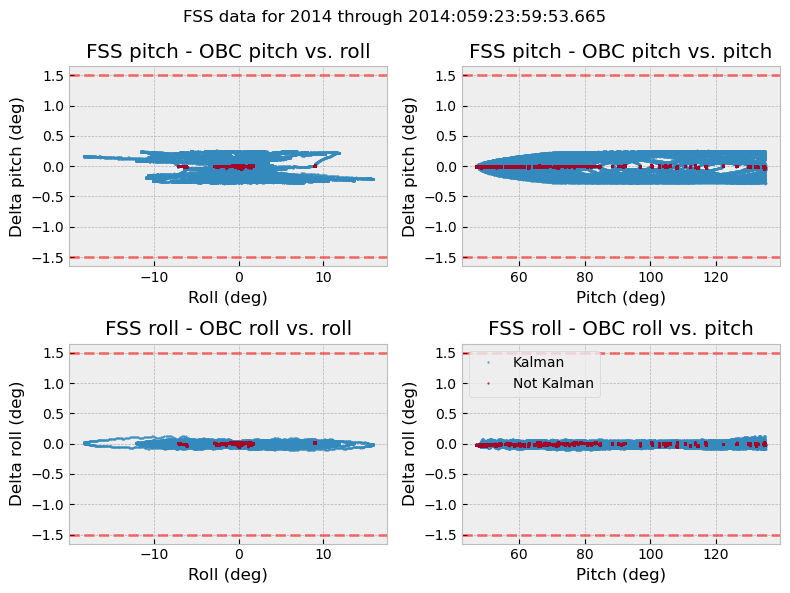

In [18]:
dat = get_fss_prim_data('2014:001', '2014:060', offset=0.0)
dat = add_pitch_roll_columns(dat)
plot_delta_vs_pitch_roll(dat);

Applying a time offset of 0.9 sec to the FSS data reduces the residuals to a minimum.

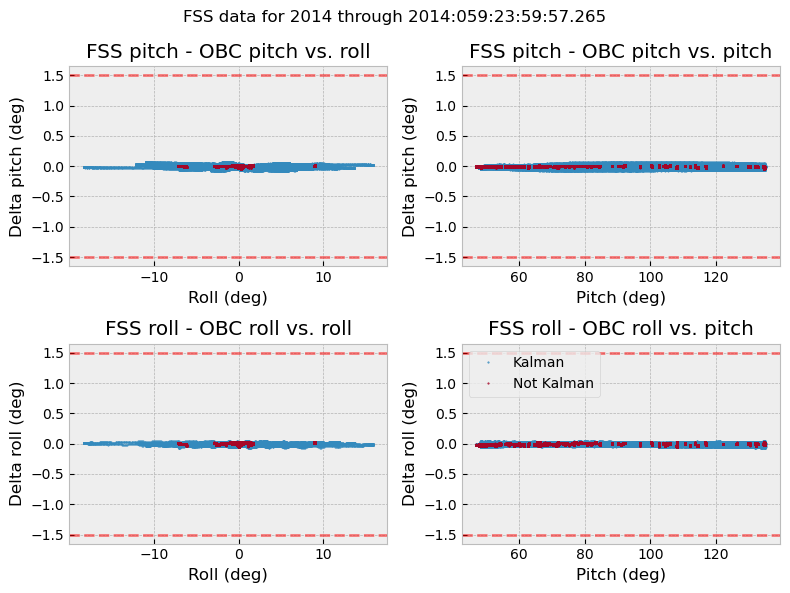

In [19]:
dat = get_fss_prim_data('2014:001', '2014:060', offset=0.9)
dat = add_pitch_roll_columns(dat)
plot_delta_vs_pitch_roll(dat);

offset=0.525, max-min delta=0.236
offset=0.575, max-min delta=0.236
offset=0.625, max-min delta=0.236
offset=0.675, max-min delta=0.236
offset=0.725, max-min delta=0.236
offset=0.775, max-min delta=0.157
offset=0.825, max-min delta=0.158
offset=0.875, max-min delta=0.158
offset=0.925, max-min delta=0.158
offset=0.975, max-min delta=0.158
offset=1.025, max-min delta=0.167
offset=1.075, max-min delta=0.309
offset=1.125, max-min delta=0.309
offset=1.175, max-min delta=0.309
offset=1.225, max-min delta=0.309
offset=1.275, max-min delta=0.311
offset=1.325, max-min delta=0.462
offset=1.375, max-min delta=0.462
offset=1.425, max-min delta=0.462
offset=1.475, max-min delta=0.462
offset=1.525, max-min delta=0.462


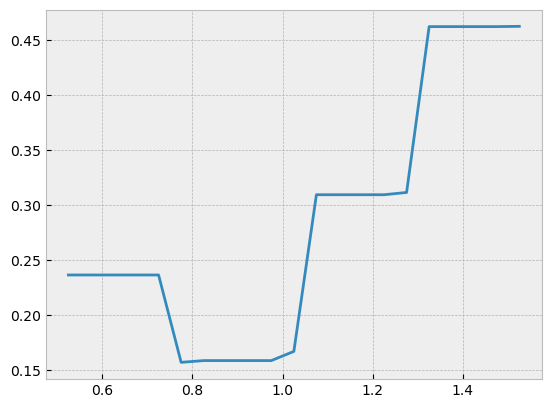

In [20]:
# Empirically play with the offset and find that 0.9 minimizes the attitude pitch
# vs pitch residuals.
offsets = 1.025 + np.linspace(-0.5, 0.5,21)
deltas = []
for offset in offsets:
    dat = get_fss_prim_data("2014:001", "2014:060", offset=offset)
    dat = add_pitch_roll_columns(dat)
    ok = (dat["pitch"] < 135) & dat["beta_sun"]
    delta = np.max(dat["pitch_fss"][ok] - dat["pitch"][ok]) - np.min(
        dat["pitch_fss"][ok] - dat["pitch"][ok]
    )
    print(f"{offset=:.3f}, max-min {delta=:.3f}")
    deltas.append(delta)

plt.plot(offsets, deltas);

### Get FSS data from 2014 - 2023 in one year chunks

In [21]:
# Global dict of FSS data keyed by year
fd = {}

In [22]:
# Read in FSS data for each year and add pitch and roll columns
# This caches the data in a compressed numpy data file, each one about 60 Mb.
for year in range(2014, 2024):
    print(year)
    start = f"{year}:001"
    if start not in fd:
        dat = get_fss_prim_data_cached(start, offset=0.9)
        dat = add_pitch_roll_columns(dat)
        fd[year] = dat

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


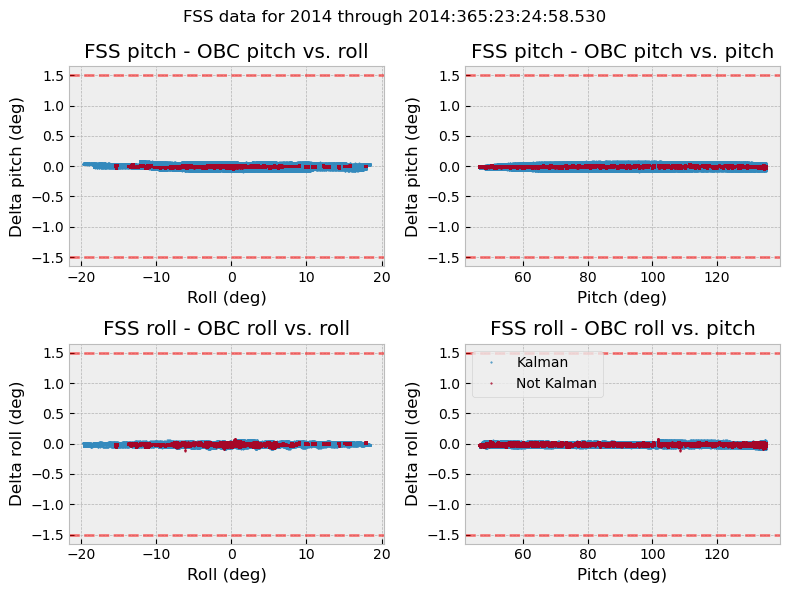

In [23]:
plot_delta_vs_pitch_roll(fd[2014])

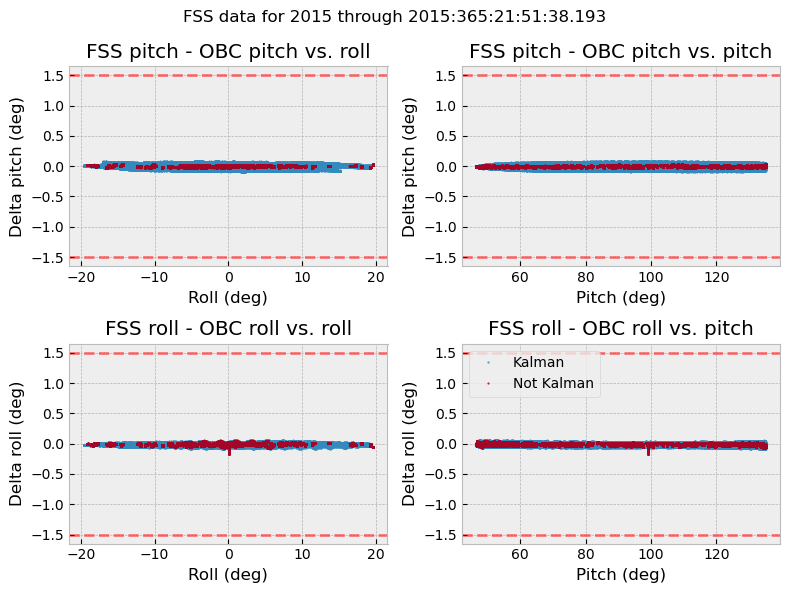

In [24]:
plot_delta_vs_pitch_roll(fd[2015])

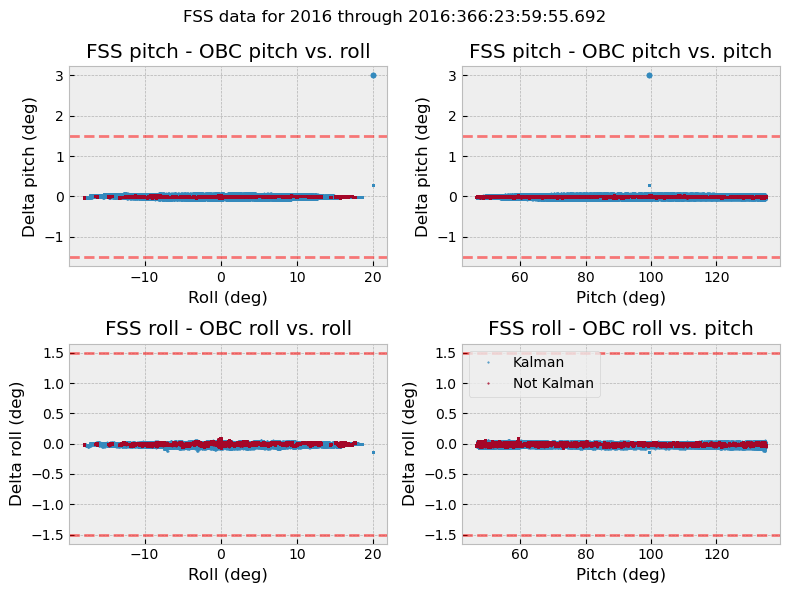

In [25]:
plot_delta_vs_pitch_roll(fd[2016])

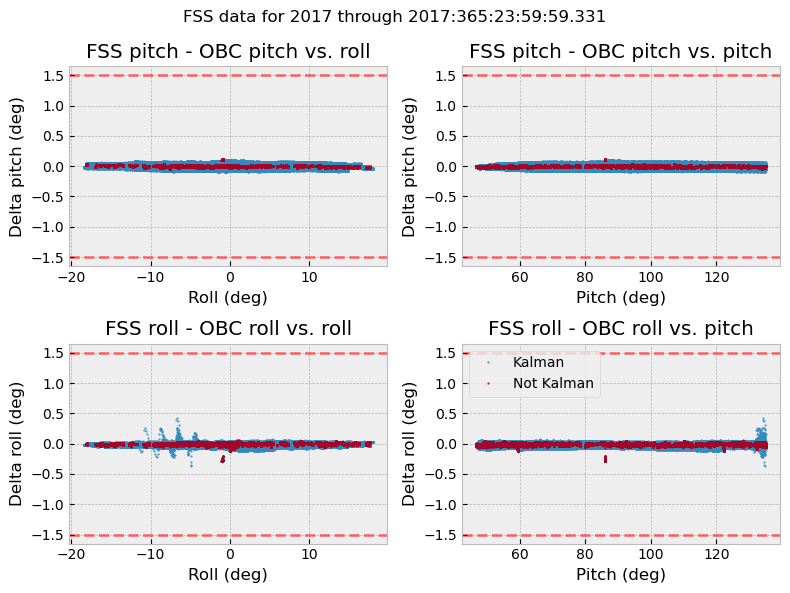

In [26]:
plot_delta_vs_pitch_roll(fd[2017])

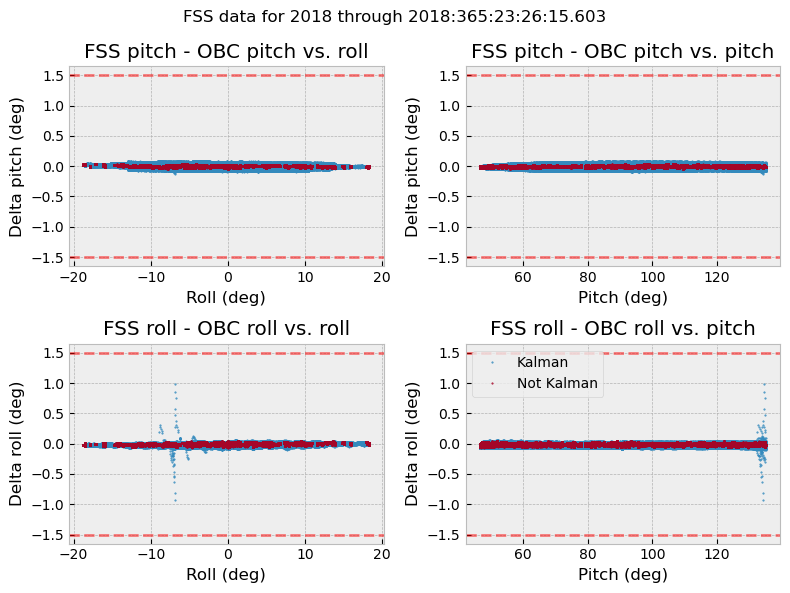

In [27]:
plot_delta_vs_pitch_roll(fd[2018])

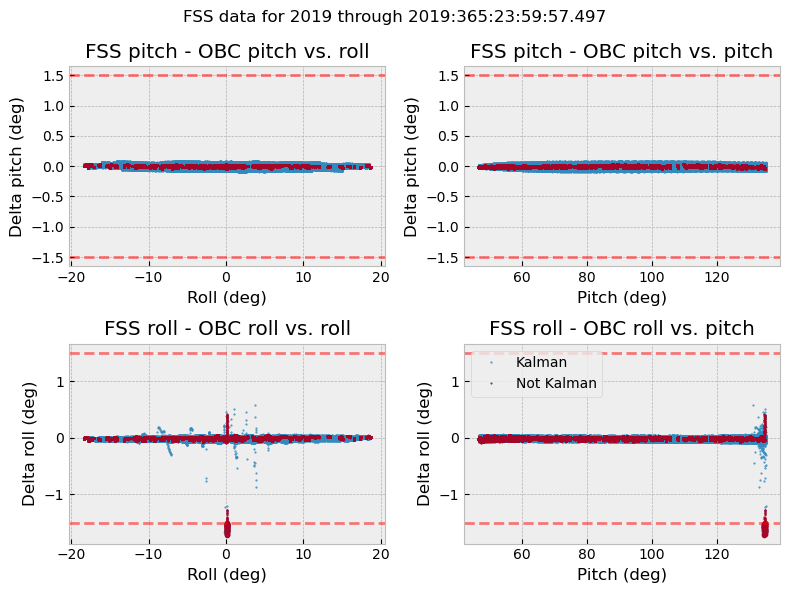

In [28]:
plot_delta_vs_pitch_roll(fd[2019])

In [29]:
get_fss_data_intervals(fd[2019], roll=0, droll=1.0, roll_err=-1.0, droll_err=0.5)

datestart,datestop,duration,tstart,tstop
str21,str21,float64,float64,float64
2019:190:16:19:03.634,2019:190:16:19:07.734,4.1,679076412.8,679076416.9
2019:338:15:30:24.104,2019:338:15:30:32.304,8.2,691860693.3,691860701.5
2019:343:16:59:33.130,2019:343:17:06:49.830,436.7,692298042.3,692298479.0
2019:346:11:51:26.245,2019:346:11:51:38.545,12.3,692538755.4,692538767.7
2019:346:17:31:27.846,2019:346:17:31:31.946,4.1,692559157.0,692559161.1
2019:356:22:35:58.699,2019:356:22:44:02.499,483.8,693441427.9,693441911.7


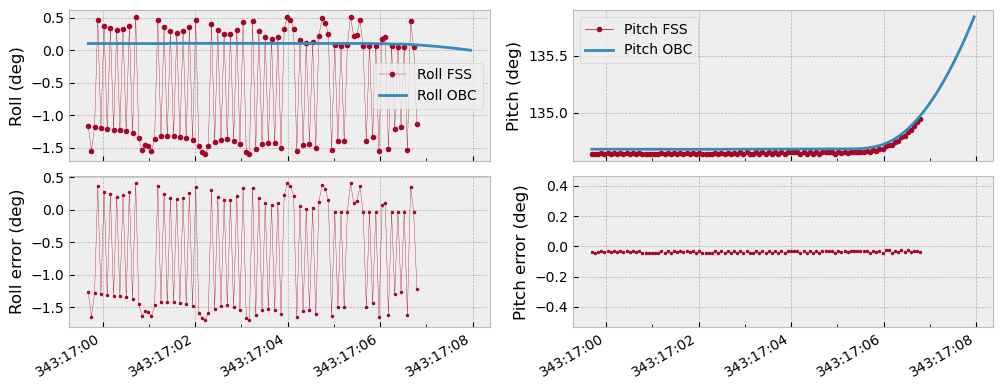

In [30]:
plot_roll_pitch_vs_time(fd[2019], '2019:343:16:30:00.00', '2019:343:17:08:00.00')

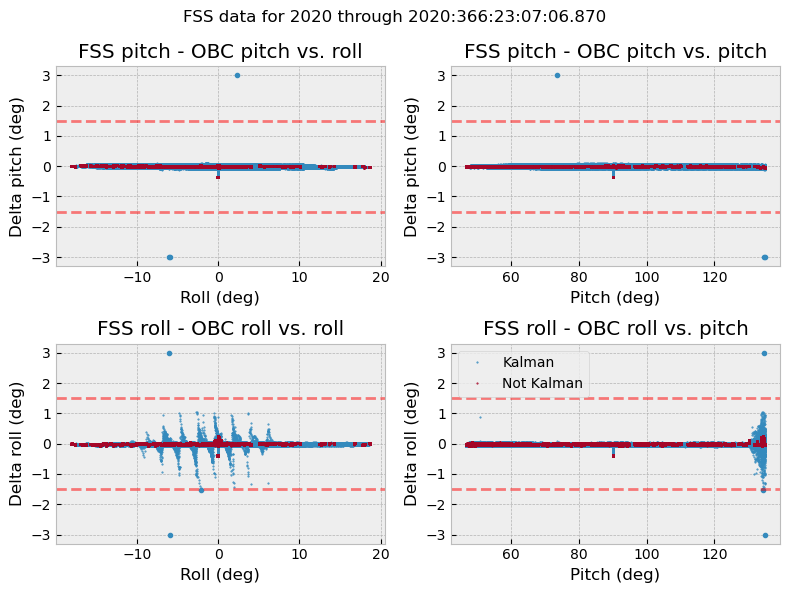

In [31]:
plot_delta_vs_pitch_roll(fd[2020])

In [32]:
get_large_fss_roll_errors(fd[2020])

date,pitch,roll,kalman,roll_err
str21,float32,float32,bool,float32
2020:026:14:16:13.630,134.34,1.85,False,-1.27
2020:034:06:12:56.970,134.88,-5.98,False,-41.09
2020:034:06:13:01.070,134.58,-5.99,False,53.20
2020:316:00:58:32.501,134.53,-2.10,False,-1.54
2020:316:00:58:36.601,134.45,-2.17,False,-1.47
2020:316:00:58:40.701,134.37,-2.25,False,-1.40
2020:316:00:58:44.801,134.29,-2.33,False,-1.31
2020:316:00:58:48.901,134.21,-2.40,False,-1.21
2020:330:04:09:01.775,134.73,2.00,False,-1.43


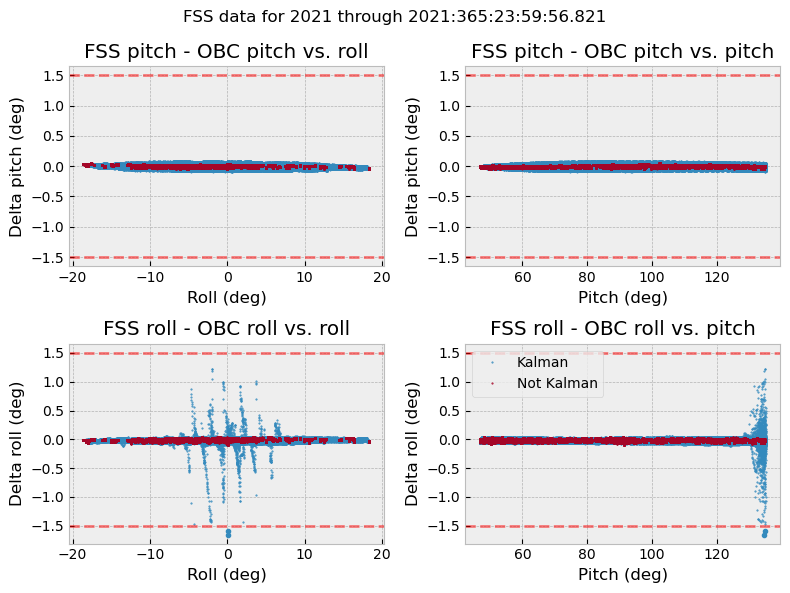

In [33]:
plot_delta_vs_pitch_roll(fd[2021])

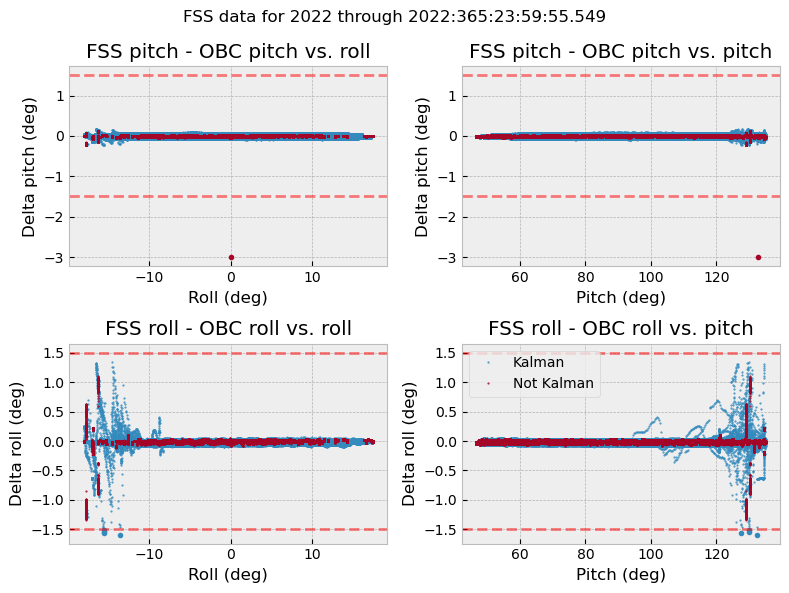

In [34]:
plot_delta_vs_pitch_roll(fd[2022])

In [35]:
get_fss_data_intervals(fd[2022], roll=-14, droll=1.0, roll_err=-1.2, droll_err=0.1)

datestart,datestop,duration,tstart,tstop
str21,str21,float64,float64,float64
2022:066:23:45:00.226,2022:067:00:59:16.927,4456.7,763083969.4,763088426.1
2022:068:14:23:29.135,2022:068:14:23:33.235,4.1,763223078.3,763223082.4
2022:070:16:01:27.146,2022:070:16:02:08.146,41.0,763401756.3,763401797.3


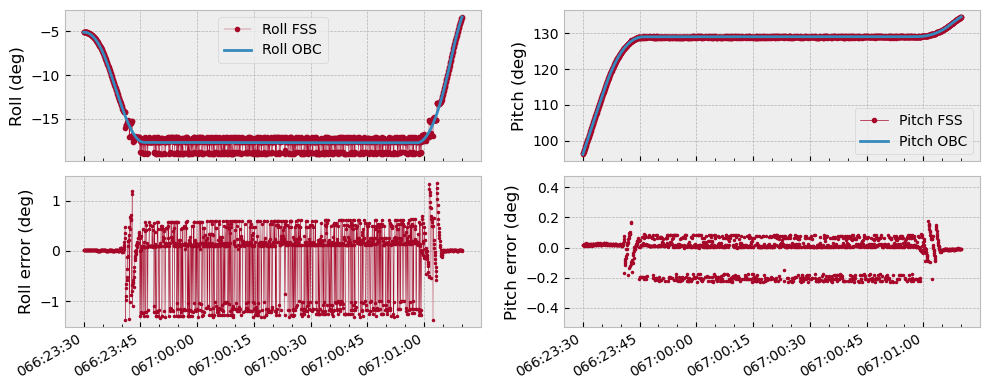

In [36]:
plot_roll_pitch_vs_time(fd[2022], "2022:066:23:30:00", '2022:067:01:10:00');

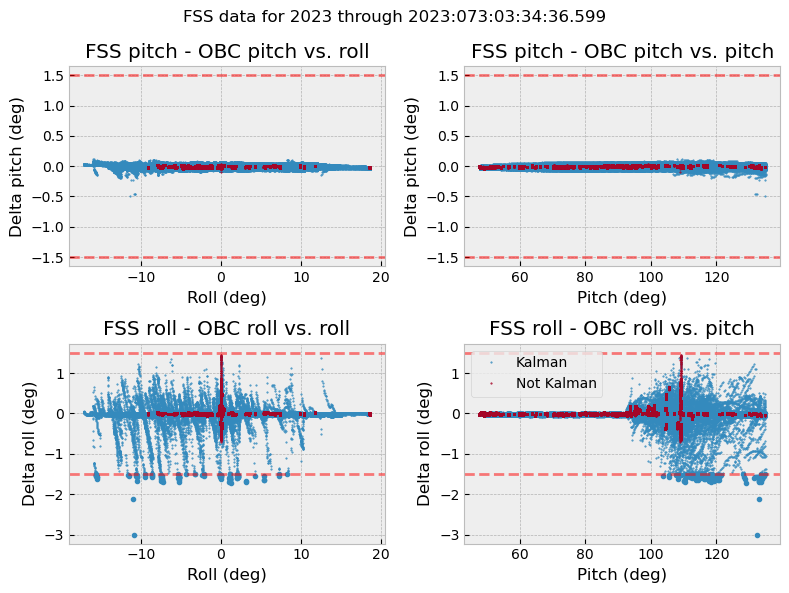

In [37]:
plot_delta_vs_pitch_roll(fd[2023])

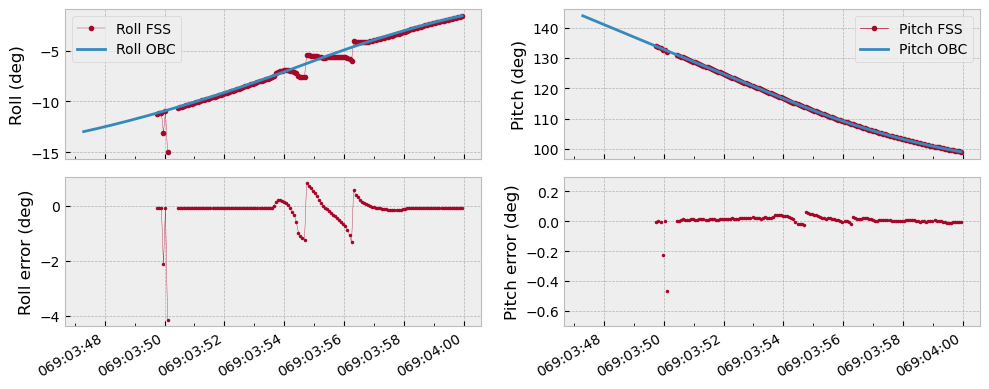

In [38]:
plot_roll_pitch_vs_time(fd[2023], "2023:069:03:30:00", '2023:069:04:00:00');

### Code to determine and plot Sun Position Monitor boundary
```
# From safe_mode_handbook for SPM:

if ACA_Sx < KP.Region_Bound :
    a = KP.X_ellipse(1) 
    b = KP.Y_ellipse(1)
else:
    a = KP.X_ellipse(2) 
    b = KP.Y_ellipse(2)

(ACA_Sx/a)^2 + (ACA_Sy/b)^2 <= 1?

# From OBC PCAD code pcad_kons.ada

 -- X-axis boundary of allowed region
    Region_Bound	: Float_Type := 
         0.0872; -- On-Orbit    SPR 571

-- X-semi-axis of ellipse defining allowed region 
    X_Ellipse		: Vector2_Type := 
         ( 1.0, 0.69466 ); -- On-Orbit     SPR 571

 -- Y-semi-axis of ellipse defining allowed region
    Y_Ellipse		: Vector2_Type := 
         ( 0.342, 0.2588 ); -- On-Orbit       <-- SPR 548
```


In [39]:
def get_spm_pitch_roll():
    """Get pitch/roll values for Sun Position Monitor."""
    KP_Region_Bound = 0.0872
    KP_X_ellipse = [1.0, 0.69466]
    KP_Y_ellipse = [0.342, 0.2588]

    theta = np.linspace(0, 2 * np.pi, 10000)
    thetas = []
    pitchs = []
    rolls = []
    for i_constraint in 0, 1:
        a = KP_X_ellipse[i_constraint]
        b = KP_Y_ellipse[i_constraint]

        x = a * np.cos(theta)
        y = b * np.sin(theta)
        z = -np.sqrt((1 - x**2 - y**2).clip(0, 1))

        pitch = np.rad2deg(arccos_clip(x))
        roll = np.rad2deg(np.arctan2(-y, -z))

        ok = x < KP_Region_Bound if i_constraint == 0 else x >= KP_Region_Bound
        thetas.append(theta[ok])
        pitchs.append(pitch[ok])
        rolls.append(roll[ok])

    theta = np.hstack(thetas)
    pitch = np.hstack(pitchs)
    roll = np.hstack(rolls)
    # Sort by theta
    idx = np.argsort(theta)
    return pitch[idx], roll[idx]

In [40]:
def plot_pitch_roll_spm_mp_constraints(dat):
    from ska_sun import ROLL_TABLE

    plt.figure(figsize=(12, 8))
    pitch, roll = get_spm_pitch_roll()
    plt.plot(pitch, roll, color="C1", label="SPM limit")
    ok = dat["alpha_sun"] & dat["beta_sun"] & (dat["pitch"] < 135)
    dok = dat[ok]
    plt.plot(dok["pitch_fss"], dok["roll_fss"], ".", ms=1, alpha=0.5, color="C0")
    bad = np.abs(dok["roll_fss"] - dok["roll"]) > 1.0
    plt.plot(
        dok["pitch_fss"][bad],
        dok["roll_fss"][bad],
        ".",
        color="C1",
        ms=4,
        label="FSS roll err > 1 deg",
    )
    bad = np.abs(dok["roll_fss"] - dok["roll"]) > 1.5
    plt.plot(
        dok["pitch_fss"][bad],
        dok["roll_fss"][bad],
        ".",
        color="r",
        ms=8,
        label="FSS roll err > 1.5 deg",
    )
    plt.plot(
        ROLL_TABLE.val["pitch"],
        ROLL_TABLE.val["rolldev"],
        color="C1",
        lw=1,
        label="Planning limit",
    )
    plt.plot(ROLL_TABLE.val["pitch"], -ROLL_TABLE.val["rolldev"], color="C1", lw=1)
    plt.xlim(None, 140)
    plt.xlabel("Pitch (deg)")
    plt.ylabel("Roll (deg)")
    plt.title(
        f'Pitch and roll from FSS data 2022 and 2023 through {CxoTime(dat["times"][-1]).date}'
    )
    plt.legend(loc="upper left")

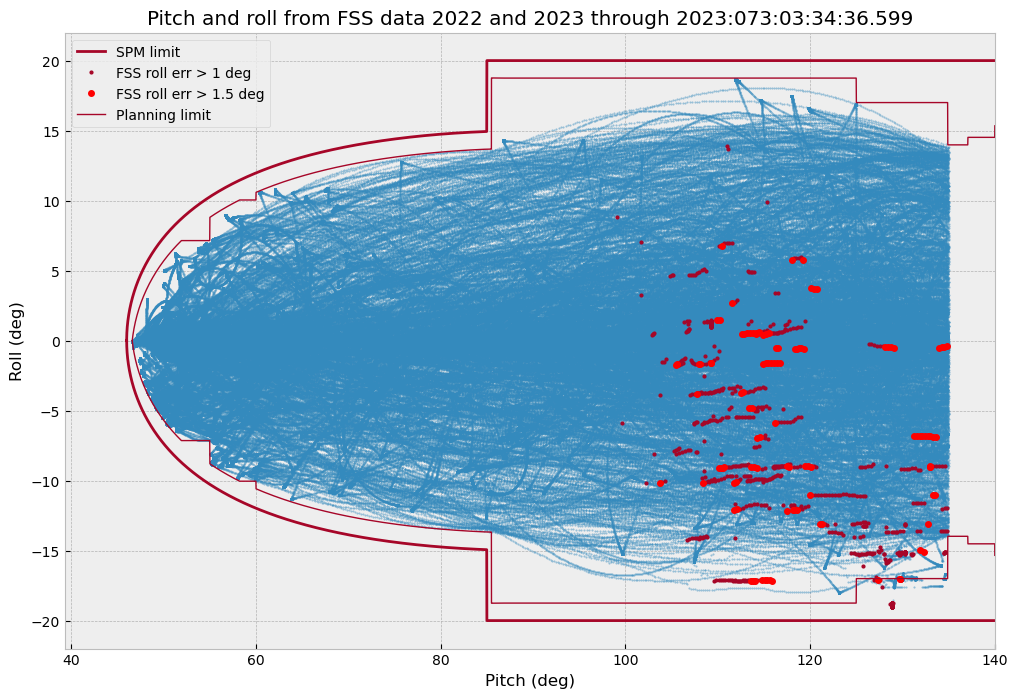

In [41]:
dat = vstack([fd[2022], fd[2023]])
plot_pitch_roll_spm_mp_constraints(dat);

In [42]:
def plot_pitches_any_kalman(out):
    """Plot pitch for all points where alpha_err > angle_err_lim.
    Cyan points are with no sun presence, red are with sun presence.
    Unlike plot_pitches() below there is no distinction made based
    on the kalman state.
    """
    times = out['times']
    pitch = out['pitch']
    roll_err = out['roll_fss'] - out['roll']
    sun = out['alpha_sun'] & out['beta_sun']

    vals = [(~sun, 'c.', 'c', 1.0, 'No Sun Presense', 8.0),
            (sun, 'bo', 'b', 0.5, 'Sun Presense (2.0 < error <= 4.0 deg)', 2.0),
            (sun, 'mo', 'm', 0.7, 'Sun Presense (4.0 < error <= 8.0 deg)', 4.0),
            (sun, 'ro', 'r', 1.0, 'Sun Presense (error > 8.0 deg)', 8.0),
            ]
    plt.figure()
    for filt, mark, mec, alpha, label, err_min in vals:
        ok = (abs(roll_err) > err_min) & filt
        if np.any(ok):
            print(label, np.count_nonzero(ok))
            plot_cxctime(times[ok], pitch[ok], mark,
                         mec=mec, label=label, alpha=alpha)

    last_date = DateTime(np.max(times)).date[:-4]

    plt.legend(loc='best', fancybox=True, framealpha=0.5)
    plt.grid('on')
    plt.title(f'Pitch for alpha error > threshold (through {last_date})')
    plt.ylabel('Pitch (deg)')


In [43]:
def plot_delta_pitch_roll_hist(filter_kalman=False, year0=2014, year1=2024):
    n_year = year1 - year0
    fig, axs = plt.subplots(n_year, 1, figsize=(10, 2 * n_year), sharex=True)
    for year, ax in zip(range(year0, year1), axs):
        dat = fd[f'{year}:001']
        pitch_fss = dat['pitch_fss']
        pitch = dat['pitch']
        roll_fss = dat['roll_fss']
        roll = dat['roll']
        ok = dat['alpha_sun'] & dat['beta_sun'] & (pitch < 135)
        if filter_kalman:
            ok = ok & dat['kalman']
        bins = np.linspace(-2.0, 2.0, 100)
        ax.hist(pitch_fss[ok] - pitch[ok], bins=bins, log=True, histtype='step', lw=1);
        ax.hist(roll_fss[ok] - roll[ok], bins=bins, log=True, histtype='step', lw=1);

KeyError: '2014:001'

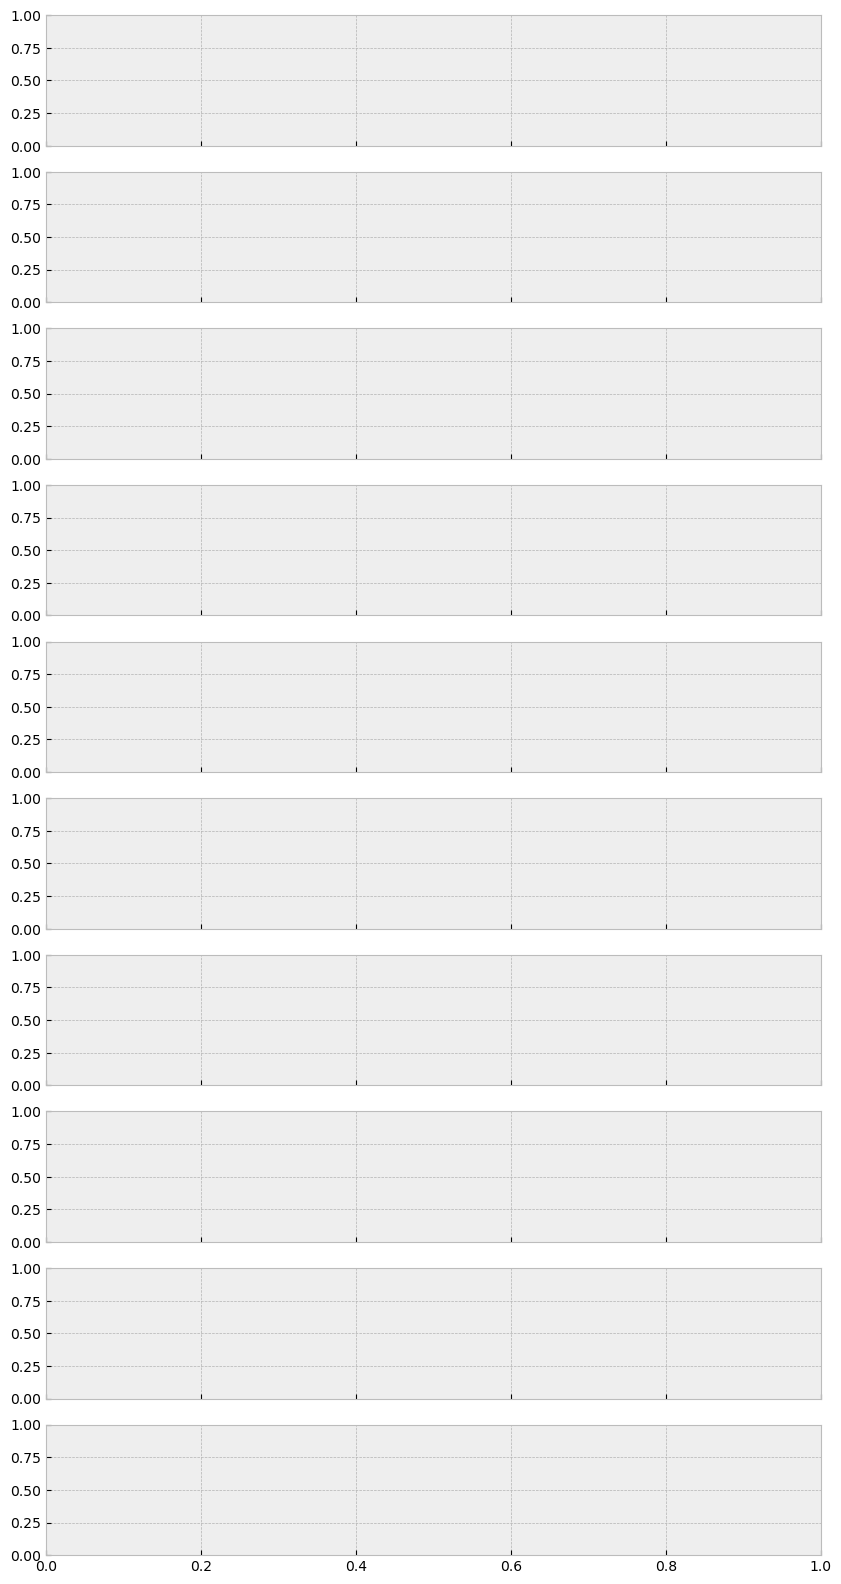

In [44]:
plot_delta_pitch_roll_hist(filter_kalman=False)